In [0]:
import os
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/mvi

In [0]:
%tensorflow_version 1.x

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from timeit import default_timer as timer
from scipy.signal import gaussian, convolve2d
import pickle
import math
import random

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K, losses
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

Set main hyperparameters of the convolutional layers and define input dataset location, size etc.

In [0]:
image_path = 'images-240p'
image_path_val = 'images-240p-val'
image_sub_path = os.path.join(image_path, 'all')
image_sub_path_val = os.path.join(image_path_val, 'all')
prescale = 1                 # Shrink factor for input images
image_h = 240 // prescale    # Original (HR) image height
image_w = 320 // prescale    # Original (HR) image width
framenum = 3                 # Number of frames in video sequences

train_size = 32              # Size of sub-images, that are generated from input data (32x32 pixels)
train_stride = 16            # Difference between two sub-images in pixels

scale = 2                    # Learn to scale by this factor
batch_size = 64
batches_per_epoch = 2048
epochs = 8

# Current best: 128/2048/32

fn = [128, 64]              # Number of filters in 1st and 2nd CNN layer
fs = [9, 3, 5]              # Sizes of filters in 1st, 2nd, 3rd CNN layer

In [0]:
# Extract luma channel from image
def extract_luma(img):
    return np.array(Image.fromarray(img).convert('YCbCr'))[:, :, 0]

# Merge luma channel with chroma channels
def merge_luma(img, luma):
    ycbcr = np.array(Image.fromarray(img).convert('YCbCr'))
    #np.clip(luma, 0, 255).astype('uint8')
    ycbcr[:, :, 0] = luma
    return np.array(Image.fromarray(ycbcr, mode='YCbCr').convert('RGB'))

# Generator of training/validating data pairs (input + expected output) in format suitable for TF
def batch_gen(batch_size, scale=2, dataset='train', upscale=True):
    if dataset == 'val':
        data_gen = ImageDataGenerator().flow_from_directory(
            image_path_val,
            target_size=(image_h, image_w),
            batch_size=4,
            class_mode=None
        )
    else:
        data_gen = ImageDataGenerator(
            #zoom_range=0.4,
            horizontal_flip=True,
            fill_mode='reflect',
            #width_shift_range=0.2,
        ).flow_from_directory(
            image_path,
            target_size=(image_h, image_w),
            batch_size=4,
            class_mode=None
        )
    
    inputs = []
    outputs = []
    for batch in data_gen:
        for output in batch:

            # numpy, (240, 320), 255
            luma = extract_luma(output.astype('uint8'))

            for i in range((image_w - train_size) // train_stride):
                for j in range((image_h - train_size) // train_stride):
                    x = i * train_stride
                    y = j * train_stride

                    # numpy, (32, 32), 255
                    luma_window = luma[y:y+train_size, x:x+train_size]
                    
                    # image, (16, 16), 255
                    lr = Image.fromarray(luma_window, mode='L').resize((train_size//scale, train_size//scale))

                    if upscale:
                        # image, (32, 32), 255
                        bicubic = lr.resize((train_size, train_size), Image.BICUBIC)
                    
                        # numpy, (32, 32, 1), 1.0
                        inputt = (np.array(bicubic) / 255).reshape((train_size, train_size, 1))

                    else:
                        # numpy, (16, 16, 1), 1.0
                        inputt = (np.array(lr) / 255).reshape((train_size//scale, train_size//scale, 1))
                    
                    # numpy, (20, 20, 1), 1.0
                    shrink = (fs[0] + fs[1] + fs[2] - 3) // 2
                    output = (luma_window[shrink:train_size-shrink, shrink:train_size-shrink] / 255) \
                        .reshape((train_size - 2 * shrink, train_size - 2 * shrink, 1))

                    # numpy, (16, 16, 1), 1.0
                    #inputt = np.clip(inputt + np.random.normal(0, 0.02, (train_size, train_size, 1)), 0, 1)

                    inputs.append(inputt)
                    outputs.append(output)

                    if len(inputs) == batch_size:
                        yield (np.array(inputs), np.array(outputs))
                        inputs = []
                        outputs = []

# Visualize LR, bicubic, HR and SRCNN output
def show_detail(x, y, pred=None, scale=2):
    fig, ax = plt.subplots(2, 3 + (pred is not None), figsize=(17, 6), dpi=100, gridspec_kw={'height_ratios': (2, 1)})
    detail1 = [slice(120, 220), slice(50, 150)]
    detail2 = [slice(60, 160), slice(200, 300)]

    imw = image_w * prescale
    imh = image_h * prescale

    print(x.shape, imw, imh, scale)

    if len(x.shape) == 3 and x.shape[2] == 3:
        mode = 'RGB'
        colorsc = dict()
    else:
        x = x.reshape((imh//scale, imw//scale))
        y = y.reshape((imh, imw))
        mode = 'L'
        colorsc = dict(
            cmap = 'Greys_r',
            vmin = 0,
            vmax = 255
        )

    ax[0, 0].set_title('Input')
    img = np.array(
        Image.fromarray(x, mode=mode).resize((imw, imh), Image.NEAREST)
    )
    ax[0, 0].imshow(img, **colorsc)
    ax[1, 0].imshow(np.hstack((img[detail1], img[detail2])), **colorsc)

    ax[0, 1].set_title('Bicubic upscale')
    img = np.array(
        Image.fromarray(x, mode=mode).resize((imw, imh), Image.BICUBIC)
    )
    ax[0, 1].imshow(img, **colorsc)
    ax[1, 1].imshow(np.hstack((img[detail1], img[detail2])), **colorsc)

    trueax = 2
    if pred is not None:
        ax[0, 2].set_title('SRCNN')
        ax[0, 2].imshow(pred, **colorsc)
        ax[1, 2].imshow(np.hstack((pred[detail1], pred[detail2])), **colorsc)
        trueax = 3
    
    ax[0, trueax].set_title('True high-res')
    ax[0, trueax].imshow(y, **colorsc)
    ax[1, trueax].imshow(np.hstack((y[detail1], y[detail2])), **colorsc)

    fig.tight_layout()
    fig.show()

def show_random_detail(scale=2):
    for x, y in batch_gen(1, scale=scale, dataset='train', upscale=False):
        x = (x[0] * 255).astype('uint8')
        y = (y[0] * 255).astype('uint8')

        show_detail(x, y, scale=scale)
        break

# TODO throws error
#show_random_detail(scale=scale)

# Visualize 2D filters of first layer
def print_first_layer(model):
    weights = model.layers[0].get_weights()[0]

    plt.figure(figsize=(24, 24))
    limits = max(abs(weights.min()), abs(weights.max()))
    for filt in range(weights.shape[3]):
        w = weights[:, :, 0, filt]

        plt.subplot(weights.shape[3] // 8, 8, filt+1)
        plt.imshow(w, cmap='PiYG', vmin=-limits, vmax=limits)
        plt.colorbar()

# Visualize second layer filters (if they are 1x1)
def print_second_layer(model):
    weights = model.layers[1].get_weights()[0]

    plt.figure(figsize=(24, 24))
    limits = max(abs(weights.min()), abs(weights.max()))

    for filt in range(weights.shape[3]):
        w = weights[0, 0, :, filt].reshape(-1, 1)

        plt.subplot(1, weights.shape[3], filt+1)
        plt.imshow(w, cmap='PiYG', vmin=-limits, vmax=limits)

        if filt == weights.shape[3] - 1:
            plt.colorbar()


laplacian_kernel = np.array([
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
    ], dtype='float32').reshape(3, 3, 1, 1)

# Loss function which combines MSE with sharpness
def mse_laplace_loss(y_true, y_pred):
    return losses.mean_squared_error(y_true, y_pred) - 0.05 * K.mean(K.conv2d(y_pred, laplacian_kernel, padding='valid'))

# Get SRCNN model (either load weights from H5 file or initialize randomly)
def get_model(weightfile=None):
    if weightfile:
        input_shape = (None, None, 1)
    else:
        input_shape = (train_size, train_size, 1)

    model = models.Sequential()
    model.add(layers.Conv2D(fn[0], (fs[0], fs[0]), activation='relu', padding='valid', input_shape=input_shape))
    model.add(layers.Conv2D(fn[1], (fs[1], fs[1]), activation='relu', padding='valid'))
    model.add(layers.Conv2D(1, (fs[2], fs[2]), activation='linear', padding='valid'))

    adam = Adam(lr=0.0003)
    #model.compile(loss=mse_laplace_loss, optimizer='adam', metrics=[mse_laplace_loss])
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

    if weightfile:
        model.load_weights(weightfile)

    return model

# Sobel kernel (edge detector)
def sobel_kernel(kernel_size=3, angle=0):
    kernel_range = list(range(- (kernel_size // 2), kernel_size // 2 + 1))
    kernel = []
    for i in kernel_range:
        kernel.append( np.array([(i * np.cos(angle) + j * np.sin(angle)) / (i*i + j*j) if i != 0 or j != 0 else 0 for j in kernel_range]) )
    return np.array(kernel)

# Gaussian kernel (smoothing filter)
def gaussian_kernel(kernel_size=3):
    probs = gaussian(kernel_size, std=1)
    return np.outer(probs, probs)

# Brutal edge detector
def half_kernel(kernel_size=3, angle=0):
    sobel = sobel_kernel(kernel_size, angle)
    return np.where(sobel > 0.0001, 1, -1)

class AccuracyHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.valloss = []

    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
    
    def on_epoch_end(self, epoch, logs={}):
        self.valloss.append((len(self.loss), logs.get('loss')))

Get randomly initialized SRCNN model and print summary

In [0]:
model = get_model()
model.summary()

Preinitialize a few filters with useful (from human opinion) values

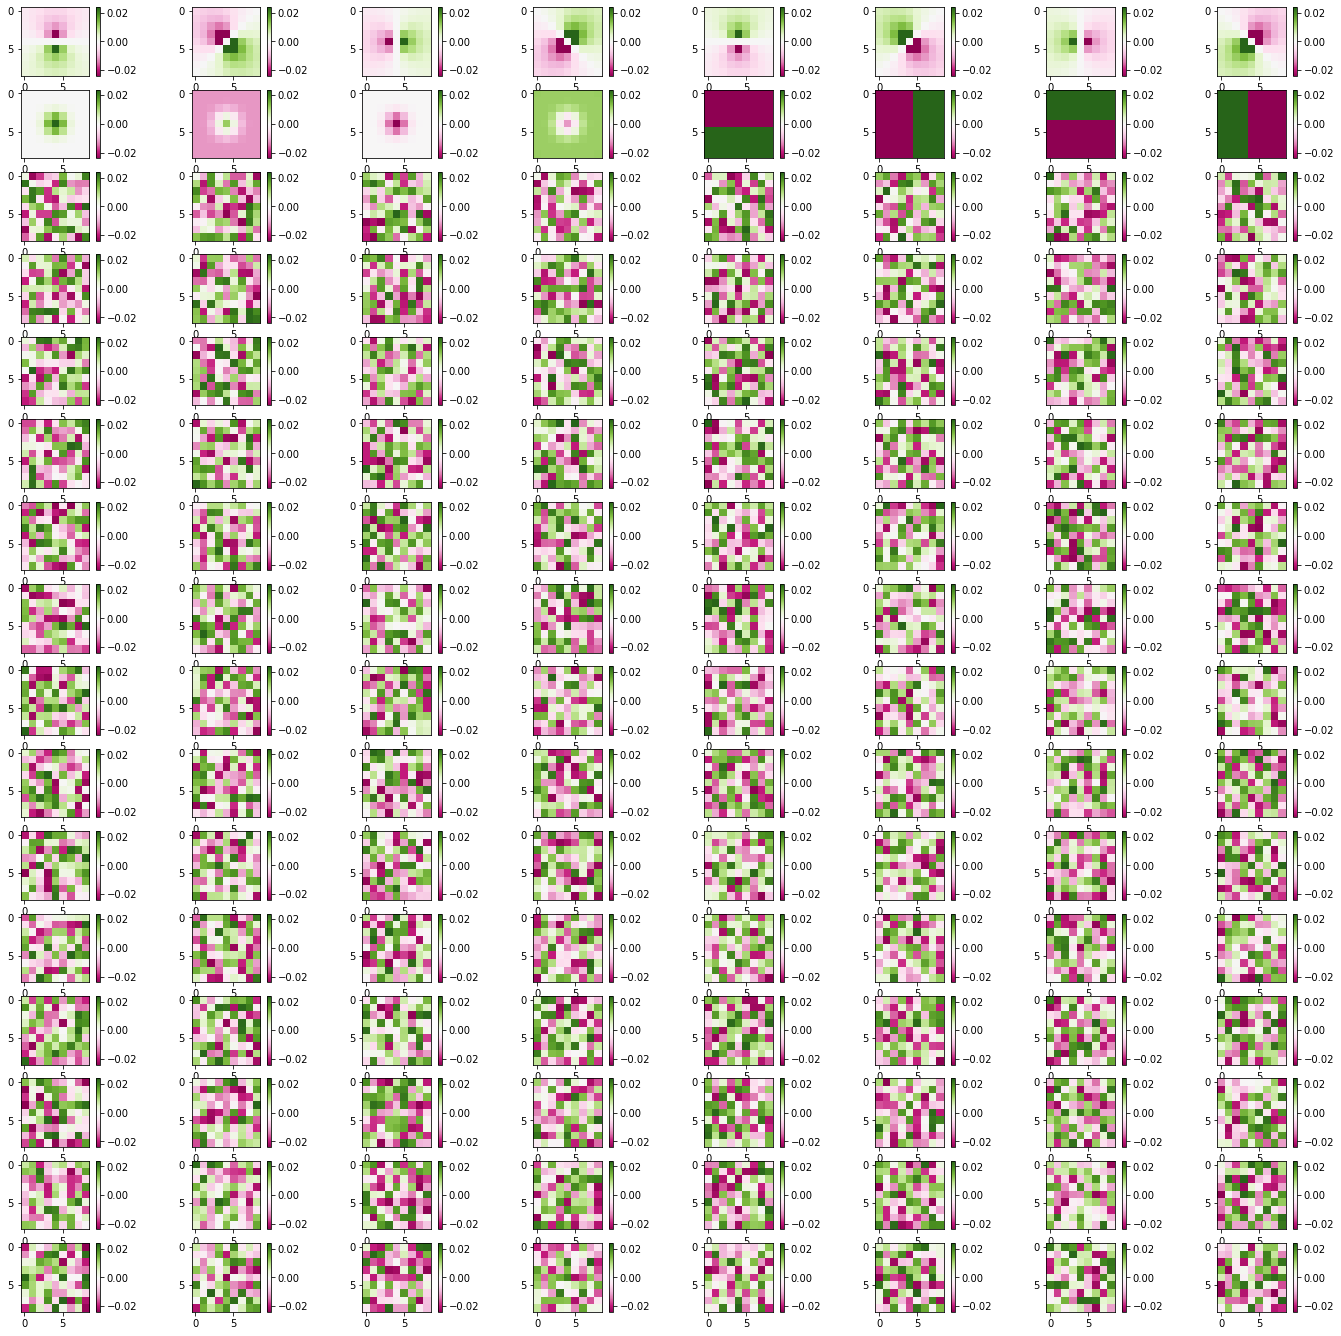

In [0]:
# Preinitialize some input layer filters to Sobel filters
weights = model.layers[0].get_weights()
maxw =  np.abs(weights[0]).max()
for i, angle in enumerate(np.linspace(0, 2*np.pi, 8+1)[:-1]):
    kernel = sobel_kernel(fs[0], angle)
    weights[0][:, :, 0, i] = kernel * maxw / kernel.max()

weights[0][:, :, 0, i+1] = gaussian_kernel(fs[0]) * maxw
weights[0][:, :, 0, i+2] = (gaussian_kernel(fs[0])-0.5) * maxw
weights[0][:, :, 0, i+3] = -gaussian_kernel(fs[0]) * maxw
weights[0][:, :, 0, i+4] = (0.5-gaussian_kernel(fs[0])) * maxw

weights[0][:, :, 0, i+5] = half_kernel(fs[0], 0) * maxw
weights[0][:, :, 0, i+6] = half_kernel(fs[0], np.pi / 2) * maxw
weights[0][:, :, 0, i+7] = half_kernel(fs[0], np.pi) * maxw
weights[0][:, :, 0, i+8] = half_kernel(fs[0], 3* np.pi / 2) * maxw

model.layers[0].set_weights(weights)

print_first_layer(model)

Train the model. Takes approximately 1-2 hours on GPU.

In [0]:
# If running on CPU, limit number of threads
#from tensorflow.keras import backend as K
#K.set_session(tf.Session(config=tf.ConfigProto(
#    intra_op_parallelism_threads=2,
#    inter_op_parallelism_threads=2)))

history = AccuracyHistory()

#save_best_only=True
checkpoint = ModelCheckpoint("best_model_train.h5", monitor='loss', verbose=1,
    mode='auto', save_freq='epoch', save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)


start = timer()

subimages_per_image = ((image_w - train_size) // train_stride) * ((image_h - train_size) // train_stride)
print(subimages_per_image)

model.fit_generator(
    batch_gen(batch_size),
    validation_data=next(batch_gen(subimages_per_image * 100, dataset='val')),
    steps_per_epoch=batches_per_epoch,
    epochs=epochs,
    callbacks=[history, checkpoint, reduce_lr]
)

duration = int(timer() - start)
print(f'Trained in {duration//60}:{duration%60:02d}')

Load saved model (it is periodically saved during training into `best_model_train.h5`)

In [0]:
#model = get_model('best_model_train.h5')
model = get_model('s2_f935_l128_e32.h5')

Load a HR image from validation set, predict superresolution image and visually compare with bicubic interpolation and expected HR image

In [0]:
imw = image_w * prescale
imh = image_h * prescale

hr = Image.open(os.path.join(image_sub_path_val, os.listdir(image_sub_path_val)[59])).resize((imw, imh))

# colored image
lr = hr.resize((imw//scale, imh//scale))

# colored 2-tensor
bicubic = np.array(hr.resize((imw//scale, imh//scale)) \
        .resize((imw, imh), Image.BICUBIC))

# luma 4-tensor
inputt = extract_luma(bicubic).reshape((-1, imh, imw, 1))

shrink = (fs[0] + fs[1] + fs[2] - 3) // 2
hr = np.array(hr)[shrink:-shrink, shrink:-shrink]
bicubic = bicubic[shrink:-shrink, shrink:-shrink]

# luma 2-tensor
pred_luma = np.clip(model.predict(inputt).reshape((imh - 2 * shrink, imw - 2 * shrink)), 0, 255).astype('uint8')
pred = merge_luma(bicubic, pred_luma)

show_detail(np.array(lr), np.array(hr), pred, scale=scale)

(120, 160, 3) 320 240 2


Print original and predicted image decomposed to Y and Cb+Cr channels

In [0]:
fig, ax = plt.subplots(1, 4, figsize=(28, 6))
ax[0].set_title('Color channels (amplified)')
ax[0].imshow(np.clip((merge_luma(bicubic, 128*np.ones_like(pred_luma)) / 255) ** 2 * 3, 0, 1))
#ax[0].imshow(merge_luma(bicubic, 128*np.ones_like(pred_luma)))
ax[1].set_title('High-res luma')
ax[1].imshow(extract_luma(np.array(hr)), cmap='gray', vmin=0, vmax=255)
ax[2].set_title('SRCNN luma')
ax[2].imshow(pred_luma, cmap='gray', vmin=0, vmax=255)
ax[3].set_title('Bicubic luma')
ax[3].imshow(extract_luma(bicubic), cmap='gray', vmin=0, vmax=255)

Compute MSE for the validation image

In [0]:
def mse(a, b):
    return ((np.array(a, dtype='float64') * 255 - np.array(b, dtype='float64') * 255) ** 2).mean() / image_w / image_h / 3

# TODO compare only luma
print('MSE (lower = better), PSRN (higher = better)')
print(f'SRCNN   MSE = {mse(pred, hr):.5f}, PSRN = {10 * np.log(255**2 / mse(pred, hr)) / np.log(10):.2f} db')
print(f'Bicubic MSE = {mse(bicubic, hr):.5f}, PSRN = {10 * np.log(255**2 / mse(bicubic, hr)) / np.log(10):.2f} db')

MSE (lower = better), PSRN (higher = better)
SRCNN   MSE = 1606.62045, PSRN = 16.07 db
Bicubic MSE = 1600.65071, PSRN = 16.09 db


Compute sharpness for the validation image

In [0]:
laplacian_kernel = np.array([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
], dtype='float32')

def sharpness(img):
    img = extract_luma(np.asarray(img))
    return convolve2d(img, laplacian_kernel, mode='valid').mean()

print('Laplacian convolution (higher = better)')
print(f'Bicubic sharpness  = {sharpness(bicubic):+.5f}')
print(f'SRCNN sharpness    = {sharpness(pred):+.5f}')
print(f'High-res sharpness = {sharpness(hr):+.5f}')

Plot training and validation loss during training. Save/load to file.

In [0]:
plt.plot(history.loss, label='training loss', alpha=0.8)
plt.plot([b for b, v in history.valloss], [v for b, v in history.valloss], label='validation loss')
plt.legend()

with open('history.pickle', 'wb') as f:
    pickle.dump({'loss': history.loss, 'valloss': history.valloss}, f)

In [0]:
with open('s2_f935_l128_e32_history.pickle', 'rb') as f:
    history_loaded = pickle.load(f)
plt.plot(pd.Series(history_loaded['loss']).rolling(512, min_periods=1).mean(), label='training loss', alpha=0.8, c='C2')
plt.plot([b for b, v in history_loaded['valloss']], [v for b, v in history_loaded['valloss']], label='validation loss', lw=2, c='C3')
plt.xlabel('Batch (batch size = 128, epoch = 2048 batches)')
plt.ylabel('Loss (MSE)')
plt.legend()

Visualize trained filters in 1st layer

In [0]:
print_first_layer(model)

In [0]:
print_second_layer(model)

# 3D convolution

Train 3D conv net on video sequences

In [0]:
train_frame_dir = 'frames-480p'
val_frame_dir = 'frames-480p-val'
train_frames = list({'-'.join(k.split('-')[:2]) for k in os.listdir(train_frame_dir)})
val_frames = list({'-'.join(k.split('-')[:2]) for k in os.listdir(val_frame_dir)})

In [0]:
# Generator of frame sequences
def batch_gen3d(batch_size, scale=2, dataset='train', upscale=True):
    if dataset == 'val':
        frame_list = val_frames
        frame_dir = val_frame_dir
    else:
        frame_list = train_frames
        frame_dir = train_frame_dir
    
    inputs = []
    outputs = []
    while True:
        for fr_name in frame_list:
            seq = [
                np.array(Image.open(f'{frame_dir}/{fr_name}-{i+1}.jpg')
                    .resize((image_w, image_h)))
                for i in range(framenum)
            ]

            # numpy, (3, 240, 320), 255
            luma = np.array([extract_luma(fr.astype('uint8')) for fr in seq])

            for i in range((image_w - train_size) // train_stride):
                for j in range((image_h - train_size) // train_stride):
                    x = i * train_stride
                    y = j * train_stride

                    # numpy, (3, 32, 32), 255
                    luma_window = luma[:, y:y+train_size, x:x+train_size]

                    # Prefer more interesting tiles
                    if luma_window.max()-luma_window.min() < 50 and random.random() < 0.95:
                        continue
                    
                    # image, 3 * (16, 16), 255
                    lr = [
                          Image.fromarray(lw, mode='L').resize((train_size//scale, train_size//scale))
                          for lw in luma_window
                    ]

                    if upscale:
                        # numpy, (3, 32, 32), 255
                        bicubic = np.array([
                            np.array(lrlayer.resize((train_size, train_size), Image.BICUBIC))
                            for lrlayer in lr
                        ])
                    
                        # numpy, (3, 32, 32, 1), 1.0
                        inputt = (bicubic / 255).reshape((framenum, train_size, train_size, 1))

                    else:
                        # numpy, (3, 16, 16, 1), 1.0
                        inputt = (np.array([np.array(lrl) for lrl in lr]) / 255) \
                            .reshape((framenum, train_size//scale, train_size//scale, 1))

                    # numpy, (1, 20, 20, 1), 1.0
                    shrink = (fs[0] + fs[1] + fs[2] - 3) // 2
                    output = (luma_window[[1], shrink:train_size-shrink, shrink:train_size-shrink] / 255) \
                        .reshape((1, train_size - 2 * shrink, train_size - 2 * shrink, 1))

                    # numpy, (3, 16, 16, 1), 1.0
                    #inputt = np.clip(inputt + np.random.normal(0, 0.02, (framenum, train_size, train_size, 1)), 0, 1)

                    inputs.append(inputt)
                    outputs.append(output)

                    if len(inputs) == batch_size:
                        yield (np.array(inputs), np.array(outputs))
                        inputs = []
                        outputs = []

Sanity check of dimensions

In [0]:
for i, o in batch_gen(2):
    print(i.shape, o.shape)
    break

Found 9900 images belonging to 1 classes.
(2, 32, 32, 1) (2, 18, 18, 1)


Visualize a few sub-sequences + expected HR frame

In [0]:
bs = 10
for i, o in batch_gen3d(bs):
    print(i.shape, o.shape)

    fig, ax = plt.subplots(bs, 1+framenum, figsize=(16, 16))
    for row in range(bs):
        for f in range(framenum):
            ax[row, f].imshow(i[row, f, :, :, 0], vmin=0)
        ax[row, framenum].imshow(o[row, 0, :, :, 0], vmin=0)
    break

(10, 3, 32, 32, 1) (10, 1, 18, 18, 1)


Create 3D SRCNN model

In [0]:
def get_model3d(weightfile=None):
    if weightfile:
        input_shape = (framenum, None, None, 1)
    else:
        input_shape = (framenum, train_size, train_size, 1)
        #input_shape = (image_h, image_w, 1)
    print(input_shape, fn, fs)

    model = models.Sequential()
    model.add(layers.Conv3D(fn[0], (framenum, fs[0], fs[0]), activation='relu', padding='valid', input_shape=input_shape))
    model.add(layers.Conv3D(fn[1], (1, fs[1], fs[1]), activation='relu', padding='valid'))
    model.add(layers.Conv3D(1, (1, fs[2], fs[2]), activation='linear', padding='valid'))

    adam = Adam(lr=0.0003)
    #model.compile(loss=mse_laplace_loss, optimizer=adam, metrics=[mse_laplace_loss])
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

    if weightfile:
        model.load_weights(weightfile)

    return model

m3 = get_model3d()
m3.summary()

(3, 32, 32, 1) [128, 64] [9, 3, 5]
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 1, 24, 24, 128)    31232     
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 22, 22, 64)     73792     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 1, 18, 18, 1)      1601      
Total params: 106,625
Trainable params: 106,625
Non-trainable params: 0
_________________________________________________________________


Train the model (1-2 hours)

In [0]:
history = AccuracyHistory()

#save_best_only=True
checkpoint = ModelCheckpoint("best_model_train.h5", monitor='loss', verbose=1,
    mode='auto', save_freq='epoch', save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)


start = timer()

subimages_per_image = ((image_w - train_size) // train_stride) * ((image_h - train_size) // train_stride)
print(subimages_per_image)

m3.fit_generator(
    batch_gen3d(batch_size),
    validation_data=next(batch_gen3d(subimages_per_image * 100, dataset='val')),
    steps_per_epoch=batches_per_epoch,
    epochs=epochs,
    callbacks=[history, checkpoint, reduce_lr]
)

duration = int(timer() - start)
print(f'Trained in {duration//60}:{duration%60:02d}')

Print training and validation loss during training

In [0]:
plt.plot(history.loss, label='training loss', alpha=0.8)
plt.plot([b for b, v in history.valloss], [v for b, v in history.valloss], label='validation loss')
plt.legend()

with open('history3d.pickle', 'wb') as f:
    pickle.dump({'loss': history.loss, 'valloss': history.valloss}, f)

In [0]:
with open('history3d_f935_l128.pickle', 'rb') as f:
    history_loaded = pickle.load(f)
plt.plot(pd.Series(history_loaded['loss']).rolling(512, min_periods=16).mean(), label='training loss', alpha=0.8, c='C2')
plt.plot([b for b, v in history_loaded['valloss']], [v for b, v in history_loaded['valloss']], label='validation loss', lw=2, c='C3')
plt.xlabel('Batch (batch size = 64, epoch = 2048 batches)')
plt.ylabel('Loss (MSE)')
plt.legend()

Load a sequence, scale it down, predict a superresolution frame from it and compare with original HR frame (with cropped borders due to VALID padding)

In [0]:
# Choose 100th (or whatever) validation sequence, load it, scale down, predict and compare
hrnum = 100
hr = [Image.open(os.path.join(val_frame_dir, f'{val_frames[hrnum]}-{i+1}.jpg')) for i in range(framenum)] 

# colored
lr = np.array([np.array(hrf.resize((image_w//scale, image_h//scale))) for hrf in hr])

def pred3d(hr):
    # colored 3-tensor
    bicubic = np.array([
        np.array(hrf.resize((image_w//scale, image_h//scale)) \
            .resize((image_w, image_h), Image.BICUBIC))
        for hrf in hr
    ])

    # luma 5-tensor
    inputt = np.array([extract_luma(bic) for bic in bicubic]).reshape((-1, framenum, image_h, image_w, 1))

    shrink = (fs[0] + fs[1] + fs[2] - 3) // 2 # - 1
    newshape=(image_h-2*shrink, image_w-2*shrink)
    hrb = np.array(hr[1])[shrink:-shrink, shrink:-shrink]
    base = bicubic[1, shrink:-shrink, shrink:-shrink]

    # luma 2-tensor
    pred_luma = np.clip(m3.predict(inputt).reshape(newshape), 0, 255).astype('uint8')
    return merge_luma(base, pred_luma), hrb

# Predicted frame, original HR image with cropped borders, 
pred, hr_cropped = pred3d(hr)

# Compare prediction with ground truth
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(pred)
ax[1].imshow(hr_cropped)